In [2]:
import pandas as pd
import surprise
from surprise import Reader,Dataset,KNNBasic,KNNWithMeans,KNNWithZScore,KNNBaseline, SVD,SVDpp,NMF,BaselineOnly
from surprise import Dataset
from surprise.model_selection import cross_validate
# from surprise import SlopeOne
# from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split


import os
import sys
import platform

import pandas as pd
import numpy as np

import time

print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- surprise: {surprise.__version__}")

- os: macOS-12.5-arm64-arm-64bit
- python: 3.8.13 (default, Mar 28 2022, 06:13:39) 
[Clang 12.0.0 ]
- pandas: 1.4.3
- numpy: 1.23.1
- surprise: 1.1.1


In [3]:
uir_df = pd.read_csv('/Users/hansungkim/Desktop/대학/DataScience/coding_set/MISS/data/final_uir_df.csv')#566875 rows
bookinfo = pd.read_csv('/Users/hansungkim/Desktop/대학/DataScience/coding_set/MISS/data/데이터_단행본도서.csv',encoding='CP949')

/var/folders/5w/hpgcl3pn32dbtpv3xcpy14280000gn/T/ipykernel_1640/2405053037.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  bookinfo = pd.read_csv('/Users/hansungkim/Desktop/대학/DataScience/coding_set/MISS/data/데이터_단행본도서.csv',encoding='CP949')


In [68]:
uir_df = uir_df[['user','item','rating']]
bookinfo = pd.merge(bookinfo,uir_df['item'],left_on = '등록번호',right_on ='item',how = 'right')
bookinfo.drop_duplicates(inplace = True)

In [69]:
uir_df.drop_duplicates(subset=['user','item'],keep = 'last',inplace = True)

In [305]:
uir_df

,user,item,rating
0,2014-예술창작학부 문예창작전공:114,E217848,3.06
1,2014-독어독문학과:51,E230327,1.82
2,2011-전자정보공학부 IT융합전공:62,E228034,1.80
3,2010-영어영문학과:3,E514713,3.24
4,2010-경영학부:4,E602448,2.94
...,...,...,...
566870,2014-전자정보공학부 전자공학전공:87,E848839,2.26
566871,2014-전자정보공학부 전자공학전공:87,E848897,1.46
566872,2017-예술창작학부 영화예술전공:6,E849410,1.56
566873,2018-소프트웨어학부:46,E847740,1.66


<AxesSubplot:xlabel='rating', ylabel='Count'>

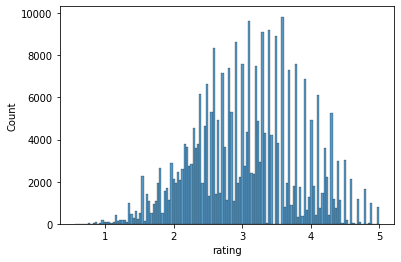

In [70]:
import seaborn as sns
sns.histplot(uir_df['rating'])

In [71]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(uir_df[["user", "item", "rating"]], reader)

## 최적 모델 생성

In [299]:
from surprise.model_selection import KFold

Best_params = {
    n_factors : 16,
    lr_all: 0.016408483971331426,
    reg_all: 0.05089362332687015
}
# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVDpp(**Best_params)


for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)


RMSE: 0.6616
RMSE: 0.6653
RMSE: 0.6657
RMSE: 0.6611
RMSE: 0.6640


# 추천 예시_User

In [300]:
def get_no_surprise(uir_df, item_info, userId):
    
    # 특정 userId가 평점을 매긴 모든 품목 리스트
    done_items = uir_df[uir_df['user'] == userId]['item'].tolist()
    
    # 모든 품목을 list 객체로 만듬. 
    total_items = item_info['등록번호'].tolist()
    
    # 한줄 for + if문으로 평가되지 않은 품목 리스트 생성
    test_items = pd.Series([ item for item in total_items if item not in done_items ],name = '등록번호')
    # not in : test_items이고 , 서명을 가져 와야함
    test_items = pd.merge(test_items,item_info[['서명','등록번호']],on = '등록번호')
    test_items.drop_duplicates('서명',keep='last',inplace = True)
    test_items.reset_index(drop=True,inplace= True)
    return test_items

In [301]:
def recomm_by_surprise(model, userId, test_items, top_n=10):
    # ,test_items['서명'][i]]
    predictions = []
    for i in test_items['등록번호']:
        predictions.append(model.predict(uid = str(userId), iid = str(i)))

    pred = pd.DataFrame(predictions)
    pred = pd.merge(pred,test_items, left_on= 'iid',right_on = '등록번호',how = 'left')
    pred = pred[['서명','est']]
    pred.sort_values('est',ascending=False,inplace = True)
    print(userId,'님을 위한 top',top_n,'추천 리스트')
    return pred[:top_n] # key에 리스트 내 객체의 정렬 기준을 입력


In [302]:
def get_read(uir_df, userId):
    
    # 특정 userId가 평점을 매긴 모든 품목 리스트
    done_items = uir_df[uir_df['user'] == userId]
    name = bookinfo[['등록번호','서명']]
    done_items = pd.merge(done_items,name,left_on='item',right_on = '등록번호',how = 'left')
    done_items = done_items[['user','서명','rating']]
    return done_items


In [303]:
userId = '2011-전자정보공학부 IT융합전공:62'
test_items = get_no_surprise(uir_df, bookinfo, userId)

In [304]:
pred = recomm_by_surprise(algo,userId, test_items,top_n=20)
pred

2011-전자정보공학부 IT융합전공:62 님을 위한 top 20 추천 리스트


,서명,est
67731,(맥머리의) 유기화학,4.506911
69446,(파비아의) 분광학강의,4.465810
46419,Organizational behavior :improving performance...,4.433715
67207,(한끝 clear) 사회조사분석사 :2급 필기 :한권으로 끝내기,4.415162
59452,(Atkins') 물리화학,4.414127
67209,(무료 동영상과 함께하는) 일반기계기사 :필기,4.404937
60592,(3D를 처음 시작하는 이들을 위한) 3ds Max 2017,4.395487
59716,(초보자를 위한) 파이썬 200제,4.374671
64359,(2018 시나공) 컴퓨터활용능력 1급 필기,4.361794
64023,(기초가 든든한) 데이터베이스 :데이터 베이스 개념과 SQL 언어를 처음 배우는 대...,4.358622


In [118]:
get_read(uir_df, userId='2011-전자정보공학부 IT융합전공:62')

,user,서명,rating
0,2011-전자정보공학부 IT융합전공:62,기초 전자 회로 실험,1.80
1,2011-전자정보공학부 IT융합전공:62,기초 전자 회로 실험,2.20
2,2011-전자정보공학부 IT융합전공:62,"총, 균, 쇠 :무기, 병균, 금속이 어떻게 문명의 불평등을 낳았는가",2.00
3,2011-전자정보공학부 IT융합전공:62,수학의 역사1 - 2,3.38
4,2011-전자정보공학부 IT융합전공:62,수학의 철학,3.58
5,2011-전자정보공학부 IT융합전공:62,"물질, 정신 그리고 수학",3.64
6,2011-전자정보공학부 IT융합전공:62,수학사 가볍게 읽기,3.20
7,2011-전자정보공학부 IT융합전공:62,수리철학의 기초,2.64
8,2011-전자정보공학부 IT융합전공:62,수학의 철학,2.78
9,2011-전자정보공학부 IT융합전공:62,그래프 이론,3.38
